## Import packages

In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import glob
import yaml
from pym3c.adata import plot_cluster
import pym3c
import os,sys
import anndata
import matplotlib.pylab as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import matplotlib as mpl
# from pym3c.adata import generate_hic_adata
from pym3c.adata import plot_cluster
mpl.style.use('default')
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = 'Arial'

## Parameters

In [2]:
rootdir = "/home/x-wding2/Projects/BG/clustering/ASC_clustering"
obs_cols = ["Region", "donor", "tech", "Study", "mCGFrac", "mCHFrac"]
palette_path = "/home/x-wding2/Projects/BG/metadata/BG_color_palette.xlsx"
metadata_path="~/Projects/BG/clustering/ASC_clustering/L1/data/L1_Astrocyte.obs.tsv"
adata_path="~/project_wubin/BG/adata/BG.100kb-HiC.h5ad"
hic_embedding_dir="~/Projects/BG/HIC/100K_embedding/raw"
hic_cell_table_path="~/Projects/BG/HIC/impute/100K_cell_table.tsv"

In [3]:
param_yaml = os.path.expanduser("~/Projects/Github/pym3c/pym3c/notebooks/clustering/ASC_clustering.yaml")
with open(param_yaml) as f:
    params = yaml.load(f, Loader=yaml.FullLoader)
rootdir="./" #os.path.abspath(os.path.expanduser(params['rootdir']))
figdir="figures"
if not os.path.exists(figdir):
    os.mkdir(figdir)
fig_basename=os.path.join(figdir,"ASC_HiC")

if adata_path is None:
    adata_path=os.path.join(rootdir,"L1/data/L1.annotated.adata.h5ad")
print(adata_path)
print(metadata_path)

~/project_wubin/BG/adata/BG.100kb-HiC.h5ad
~/Projects/BG/clustering/ASC_clustering/L1/data/L1_Astrocyte.obs.tsv


## Merge cell type annotation

In [4]:
from pym3c.clustering import embedding
from sklearn.preprocessing import StandardScaler

def hic_worker_svd(input_dir,file,ndim,sel):
	from sklearn.decomposition import TruncatedSVD
	data = np.load(os.path.join(input_dir, file))['arr_0']
	model = TruncatedSVD(n_components=ndim, algorithm='arpack')
	decomp = model.fit_transform(data[sel])
	decomp = decomp[:, model.singular_values_ > 0]
	singular_values = model.singular_values_[model.singular_values_ > 0]
	decomp /= singular_values[None, :]  # tmp_reduce / model.singular_values_
	return decomp #shape=(n_cells, ndim)

def generate_hic_adata(
    input_dir, cell_meta,cell_table_path, ndim=50,n_jobs=-1,
    key_added='X_pca',output=None,**kwargs):
    """
    Generate HiC embedding anndata:
    For example:
        pym3c adata generate_hic_adata  --input_dir ~/Projects/BICAN/HIC/100K_embedding/raw \
              --cell_meta ~/Projects/BG/metadata/BG_BICAN_metadata.tsv.gz \
              --cell_table_path /anvil/projects/x-mcb130189/Wubin/BICAN/HIC/impute/100K_cell_table.tsv \
              --output ~/Projects/BG/adata/BG_BICAN.100kb.HiC.h5ad \
              --std_cutoff None --n_jobs 24 --min_cell=None --impute False --normalize_per_cell=False --downsample 100000 --batch_col="['donor']"
    
    Parameters
    ----------
    input_dir :path
        path for HiC embedding dir, such as 100kb embedding raw dir, under this
        dir, each file is a embedding matrix for each chrom.
    cell_meta :path
        path for cell meta scripts path.
    cell_table_path :path
        path for HiC cell table, two columns, 1st is cell, 2nd is path.
    ndim :int
        number of dimension [50]
    output :path
        output path for the generated adata, it None, will not write to file [None]
    run_embedding: bool
        whether to run dimension reduction on the resulting adata
    kwargs: dict
        pass to embedding, such as run_embedding False --use_rep X_pca,-use_lsi True
    Returns
    -------
    adata
    """
    from sklearn.decomposition import TruncatedSVD
    import multiprocessing
    # multiprocessing.set_start_method("spawn", force=True)
    from tqdm import tqdm
    assert not output is None
    output = os.path.abspath(os.path.expanduser(output))
    input_dir=os.path.expanduser(input_dir)
    cell_table = pd.read_csv(cell_table_path, sep='\t', index_col=0,
                             header=None, names=['cell', 'path']).squeeze()
    cmetadata = pd.read_csv(cell_meta, index_col=0, sep='\t')
    keep_cells = list(set(cell_table.index.tolist()) & set(cmetadata.index.tolist()))
    sel = cell_table.index.to_series().isin(keep_cells).values  # bool array
    cmetadata = cmetadata.loc[cell_table[sel].index.tolist()]
    total_data = []
    if n_jobs==-1:
        n_jobs=os.cpu_count()
    pool = multiprocessing.Pool(n_jobs)
    jobs = []
    worker=hic_worker_svd
    for file in os.listdir(input_dir): # for each chrom, cells are the same order as cell_table
        job = pool.apply_async(worker, (input_dir, file, ndim, sel,))
        jobs.append(job)
    with tqdm(total=len(jobs), colour='blue') as pbar:
        for job in jobs:
            total_data.append(job.get())
            pbar.update(1)
    total_data = np.concatenate(total_data, axis=1)  # ncells, ndim * n_chrs
    
    adata = anndata.AnnData(X=np.ones((cmetadata.shape[0], 1)),
                            obs=cmetadata)
    # final SVD
    model = TruncatedSVD(n_components=ndim, algorithm='arpack')
    decomp = model.fit_transform(total_data)
    decomp = decomp[:, model.singular_values_ > 0]
    singular_values = model.singular_values_[model.singular_values_ > 0]
    decomp /= singular_values[None, :]
    # extra normalizition
    scaler = StandardScaler(with_mean=True)
    embeddings_normalized = scaler.fit_transform(decomp)
    adata.obsm[key_added] = embeddings_normalized
    
    # run tsne & umap
    # raw_adata_path = output.replace('.h5ad', '.raw.h5ad')
    ebd=kwargs.pop('run_embedding',False)
    embedding(adata, run_embedding=False,output=output, **kwargs) # Do not run PCA
    return output

In [5]:
output=fig_basename+".ASC.HiC.100kb.h5ad"
output_adata_path=generate_hic_adata(
                        input_dir=hic_embedding_dir,cell_meta=metadata_path,
                        cell_table_path=hic_cell_table_path,key_added='X_pca',
                        output=output,impute=False,normalize_per_cell=False,
                        n_jobs=8,resolution=0.5,p_cutoff=0.05)
output_adata_path=output

  0%|                                                                                                                                                                                                                | 0/24 [00:00<?, ?it/s]

  4%|████████▎                                                                                                                                                                                               | 1/24 [00:31<11:59, 31.28s/it]

 12%|█████████████████████████                                                                                                                                                                               | 3/24 [00:55<06:00, 17.17s/it]

 54%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                           | 13/24 [01:01<00:35,  3.22s/it]

 58%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                   | 14/24 [01:03<00:30,  3.06s/it]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 16/24 [01:26<00:40,  5.11s/it]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 21/24 [01:27<00:08,  2.84s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [01:27<00:00,  3.65s/it]

2025-08-15 11:11:13.978 | INFO     | pym3c.clustering:embedding:466 - knn: 26


2025-08-15 11:11:13.979 | INFO     | pym3c.clustering:embedding:474 - Calculating umap, leiden and tsne for X_pca


AnnData object with n_obs × n_vars = 8289 × 1 backed at '/anvil/projects/x-mcb130189/Wubin/BG/clustering/ASC_clustering/L1/figures/ASC_HiC.ASC.HiC.100kb.h5ad'
    obs: 'alpha', 'beta', 'prior_mean', 'Key', 'Study', 'tech', 'donor', 'leiden', 'InputReadPairs', 'InputReadPairsBP', 'TrimmedReadPairs', 'R1WithAdapters', 'R1QualTrimBP', 'R1TrimmedReadsBP', 'R2WithAdapters', 'R2QualTrimBP', 'R2TrimmedReadsBP', 'UniqueMappedReads', 'UniqueMappingRate', 'MultiMappedReads', 'MultiMappingRate', 'OverallMappingRate', 'R1UniqueMappedReads', 'R1MultiMappedReads', 'R1UniqueMappingRate', 'R1MultiMappingRate', 'R1OverallMappingRate', 'R2UniqueMappedReads', 'R2MultiMappedReads', 'R2UniqueMappingRate', 'R2MultiMappingRate', 'R2OverallMappingRate', 'UniqueAlignFinalReads', 'UniqueAlignDuplicatedReads', 'UniqueAlignPCRDuplicationRate', 'CisContacts', 'CisCutContacts', 'CisMultiContacts', 'CisCutMultiContacts', 'TransContacts', 'TransCutContacts', 'TransMultiContacts', 'TransCutMultiContacts', 'ChimericCon

In [4]:
output=fig_basename+".ASC.HiC.100kb.h5ad"
adata=anndata.read_h5ad(output)
adata

AnnData object with n_obs × n_vars = 8289 × 1
    obs: 'alpha', 'beta', 'prior_mean', 'Key', 'Study', 'tech', 'donor', 'InputReadPairs', 'InputReadPairsBP', 'TrimmedReadPairs', 'R1WithAdapters', 'R1QualTrimBP', 'R1TrimmedReadsBP', 'R2WithAdapters', 'R2QualTrimBP', 'R2TrimmedReadsBP', 'UniqueMappedReads', 'UniqueMappingRate', 'MultiMappedReads', 'MultiMappingRate', 'OverallMappingRate', 'R1UniqueMappedReads', 'R1MultiMappedReads', 'R1UniqueMappingRate', 'R1MultiMappingRate', 'R1OverallMappingRate', 'R2UniqueMappedReads', 'R2MultiMappedReads', 'R2UniqueMappingRate', 'R2MultiMappingRate', 'R2OverallMappingRate', 'UniqueAlignFinalReads', 'UniqueAlignDuplicatedReads', 'UniqueAlignPCRDuplicationRate', 'CisContacts', 'CisCutContacts', 'CisMultiContacts', 'CisCutMultiContacts', 'TransContacts', 'TransCutContacts', 'TransMultiContacts', 'TransCutMultiContacts', 'ChimericContacts', 'NoContacts', 'MappedFragments', 'DeduppedContacts', 'ContactsDeduplicationRate', 'TotalCisContacts', 'TotalTransCo

In [5]:
metadata=pd.read_csv(os.path.expanduser(metadata_path),sep='\t',index_col=0)
ovlp_cells=list(set(metadata.index.tolist()) & set(adata.obs_names))
adata=adata[ovlp_cells,:]
adata.obs=metadata.loc[adata.obs_names]
clustering_name_annot='ASC_Group'
adata.obs

alpha      beta  \
UCI4723_CX17_GP_1_P10-1-I17-H11                 4.874367  0.968568   
HBA_220603_H1930004_CX46_NAC_3C_1_P6-5-M9-F10   5.175978  1.048695   
UWA7648_CX151718_CaH_1_P6-1-I2-N1               5.623922  0.965512   
UCI4723_CX17_GP_1_P2-1-P13-G8                   6.086036  1.236295   
UCI4723_CX181920_SubTH_1_P5-1-C23-K20           6.264650  1.237934   
...                                                  ...       ...   
HBA_220224_H1930001_CX45_CaB_3C_1_P2-3-K18-E17  5.204346  1.181809   
UCI2424_CX17_GP_1_P1-1-J12-E23                  4.668003  0.809012   
HBA_220610_H1930004_CX47_GPe_3C_1_P5-1-I24-L2   5.038784  1.024598   
UCI2424_CX12_NAC_1_P7-1-N22-J18                 7.287253  1.034643   
UCI4723_CX17_GP_1_P7-1-B19-F15                  7.193888  1.471120   

                                                prior_mean  \
UCI4723_CX17_GP_1_P10-1-I17-H11                   0.834233   
HBA_220603_H1930004_CX46_NAC_3C_1_P6-5-M9-F10     0.831526   
UWA7648_CX151718_CaH_1_P6-1-I2-N1                 0.853476   
UCI4723_CX17_GP_1_P2-1-P13-G8                     0.831161   
UCI4723_CX181920_SubTH_1_P5-1-C23-K20             0.834999   
...                                                    ...   
HBA_220224_H1930001_CX45_CaB_3C_1_P2-3-K18-E17    0.814942   
UCI2424_CX17_GP_1_P1-1-J12-E23                    0.852290   
HBA_220610_H1930004_CX47_GPe_3C_1_P5-1-I24-L2     0.831019   
UCI2424_CX12_NAC_1_P7-1-N22-J18                   0.875672   
UCI4723_CX17_GP_1_P7-1-B19-F15                    0.830223   

                                                                      Key  \
UCI4723_CX17_GP_1_P10-1-I17-H11                 SALK290_SALK297.100kb-CGN   
HBA_220603_H1930004_CX46_NAC_3C_1_P6-5-M9-F10     HBA_snm3C_NAC.100kb-CGN   
UWA7648_CX151718_CaH_1_P6-1-I2-N1                       SALK022.100kb-CGN   
UCI4723_CX17_GP_1_P2-1-P13-G8                   SALK290_SALK297.100kb-CGN   
UCI4723_CX181920_SubTH_1_P5-1-C23-K20           SALK195_SALK198.100kb-CGN   
...                                                                   ...   
HBA_220224_H1930001_CX45_CaB_3C_1_P2-3-K18-E17    HBA_snm3C_CaB.100kb-CGN   
UCI2424_CX17_GP_1_P1-1-J12-E23                  SALK296_SALK298.100kb-CGN   
HBA_220610_H1930004_CX47_GPe_3C_1_P5-1-I24-L2     HBA_snm3C_GPe.100kb-CGN   
UCI2424_CX12_NAC_1_P7-1-N22-J18                 SALK148_SALK149.100kb-CGN   
UCI4723_CX17_GP_1_P7-1-B19-F15                  SALK290_SALK297.100kb-CGN   

                                                Study   tech     donor  \
UCI4723_CX17_GP_1_P10-1-I17-H11                 BICAN  snm3C   UCI4723   
HBA_220603_H1930004_CX46_NAC_3C_1_P6-5-M9-F10     HBA  snm3C  H1930004   
UWA7648_CX151718_CaH_1_P6-1-I2-N1               BICAN  snm3C   UWA7648   
UCI4723_CX17_GP_1_P2-1-P13-G8                   BICAN  snm3C   UCI4723   
UCI4723_CX181920_SubTH_1_P5-1-C23-K20           BICAN  snm3C   UCI4723   
...                                               ...    ...       ...   
HBA_220224_H1930001_CX45_CaB_3C_1_P2-3-K18-E17    HBA  snm3C  H1930001   
UCI2424_CX17_GP_1_P1-1-J12-E23                  BICAN  snm3C   UCI2424   
HBA_220610_H1930004_CX47_GPe_3C_1_P5-1-I24-L2     HBA  snm3C  H1930004   
UCI2424_CX12_NAC_1_P7-1-N22-J18                 BICAN  snm3C   UCI2424   
UCI4723_CX17_GP_1_P7-1-B19-F15                  BICAN  snm3C   UCI4723   

                                                leiden  InputReadPairs  \
UCI4723_CX17_GP_1_P10-1-I17-H11                      0         1526721   
HBA_220603_H1930004_CX46_NAC_3C_1_P6-5-M9-F10        3         2127404   
UWA7648_CX151718_CaH_1_P6-1-I2-N1                    1         1635132   
UCI4723_CX17_GP_1_P2-1-P13-G8                        4         2595180   
UCI4723_CX181920_SubTH_1_P5-1-C23-K20                3         3204692   
...                                                ...             ...   
HBA_220224_H1930001_CX45_CaB_3C_1_P2-3-K18-E17       3         1980092   
UCI2424_CX17_GP_1_P1-1-J12-E23                       0     

In [6]:
adata.obs[clustering_name_annot].unique()

array(['GM exSTRd', 'WM', 'GM STR'], dtype=object)

In [7]:
keep_cells=adata.obs.loc[adata.obs[clustering_name_annot]!='doublet'].index.tolist()
adata=adata[keep_cells,:]

In [8]:
cols=[]
for col in adata.obs.columns.tolist():
    if adata.obs[col].dropna().nunique()==0:
        cols.append(col)
adata.obs.drop(cols,inplace=True,axis=1)
print(cols)
adata.strings_to_categoricals()

[]


## Visualization

### Plot annotated clusters

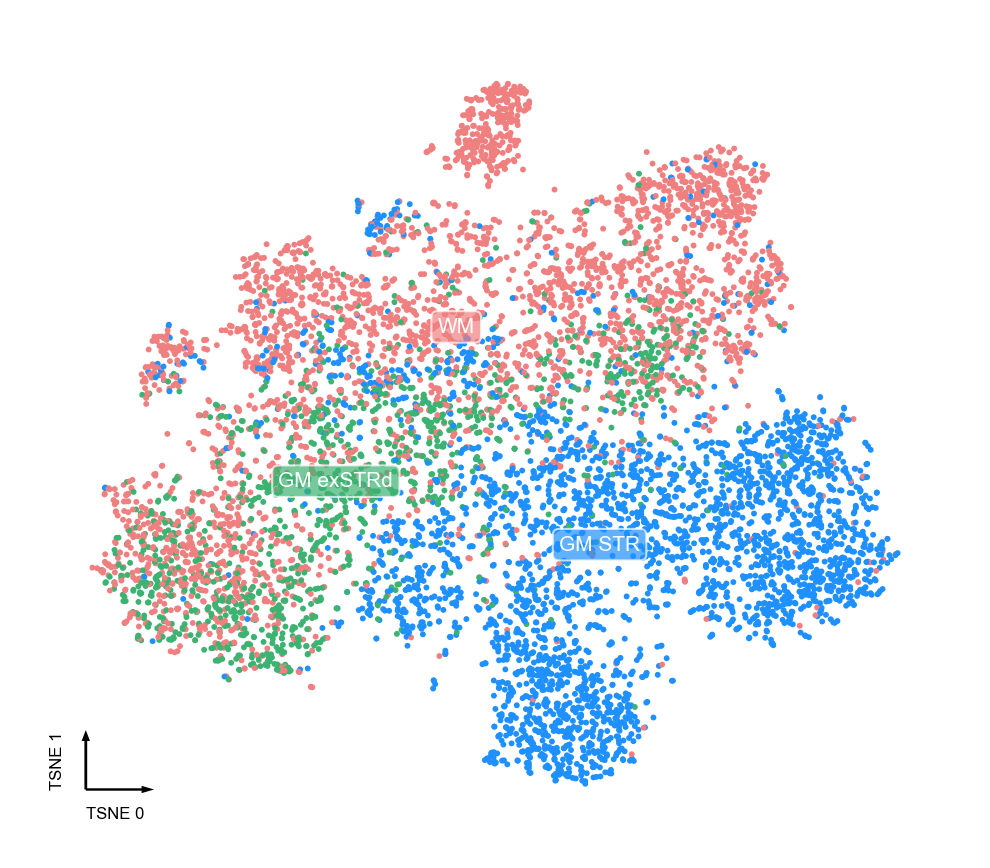

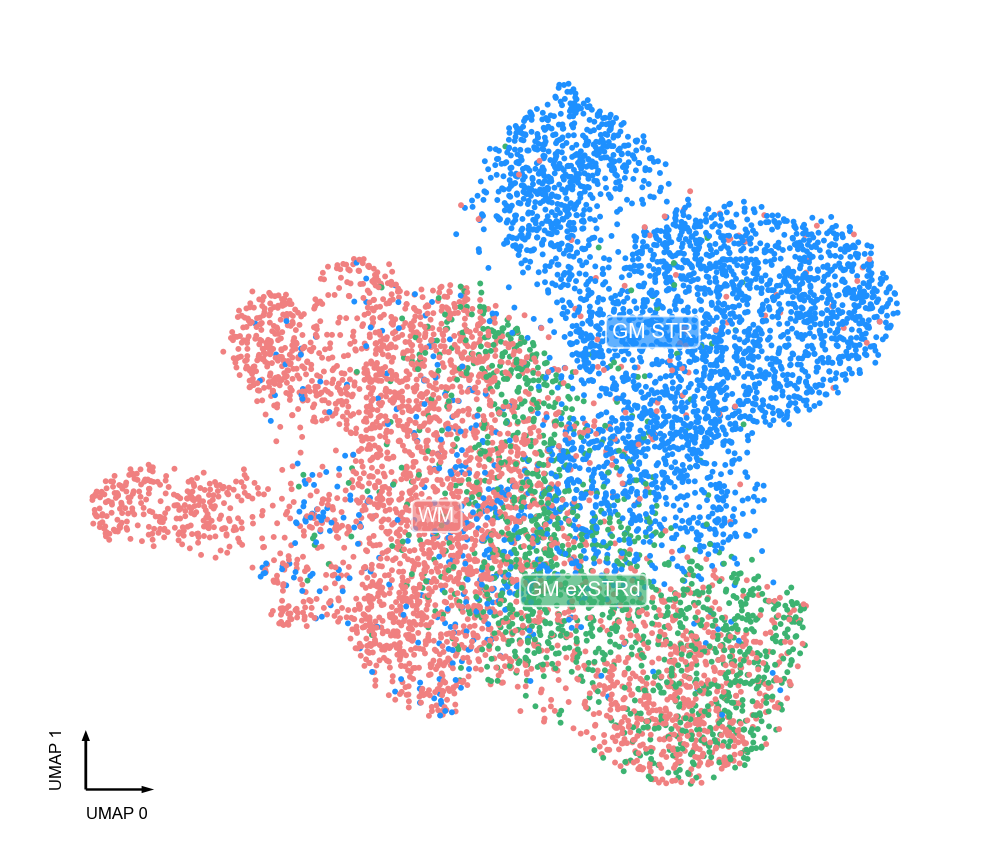

In [10]:
# with text annotation
group_colors=pd.read_excel(os.path.expanduser(palette_path),sheet_name='ASC',index_col=0).Hex.to_dict()
for coord_base in ['tsne','umap']:
    plot_cluster(adata_path=adata,coord_base=coord_base,cluster_col=clustering_name_annot,
         coding=False,palette_path=group_colors,ncol=1,show_legend=False,
         output=f"{fig_basename}.annotated.{coord_base}.{clustering_name_annot}_with_text.pdf")

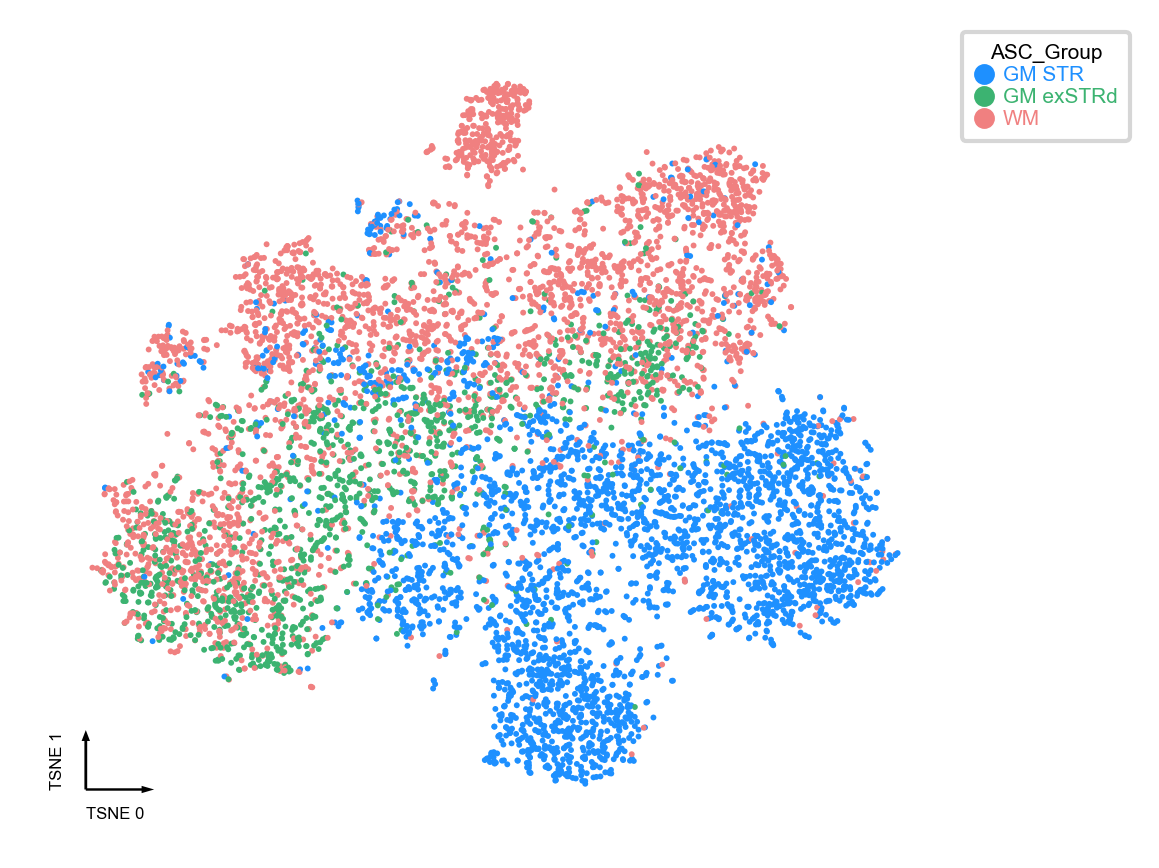

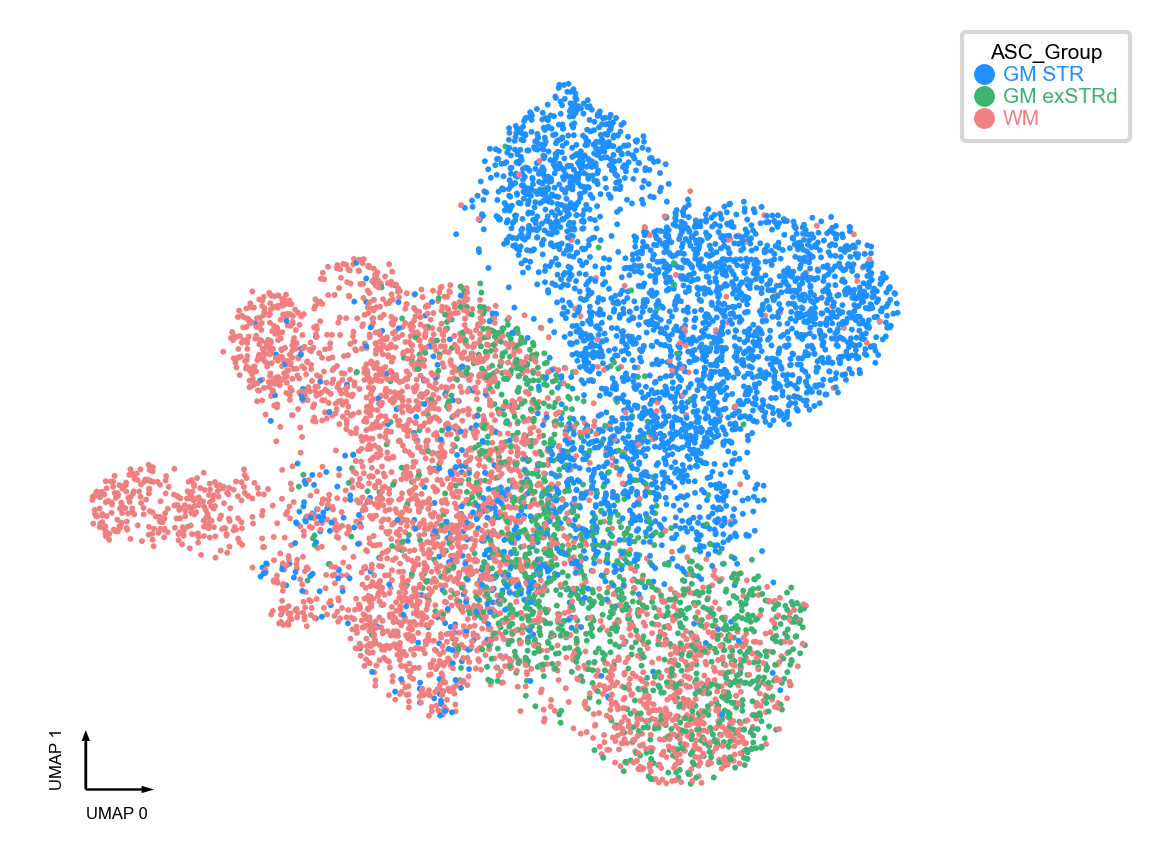

In [11]:
# no text annotation
for coord_base in ['tsne','umap']:
    plot_cluster(adata_path=adata,coord_base=coord_base,cluster_col=clustering_name_annot,
         coding=False,palette_path=group_colors,ncol=1,
         output=f"{fig_basename}.annotated.{coord_base}.{clustering_name_annot}.pdf",
        text_anno=None)

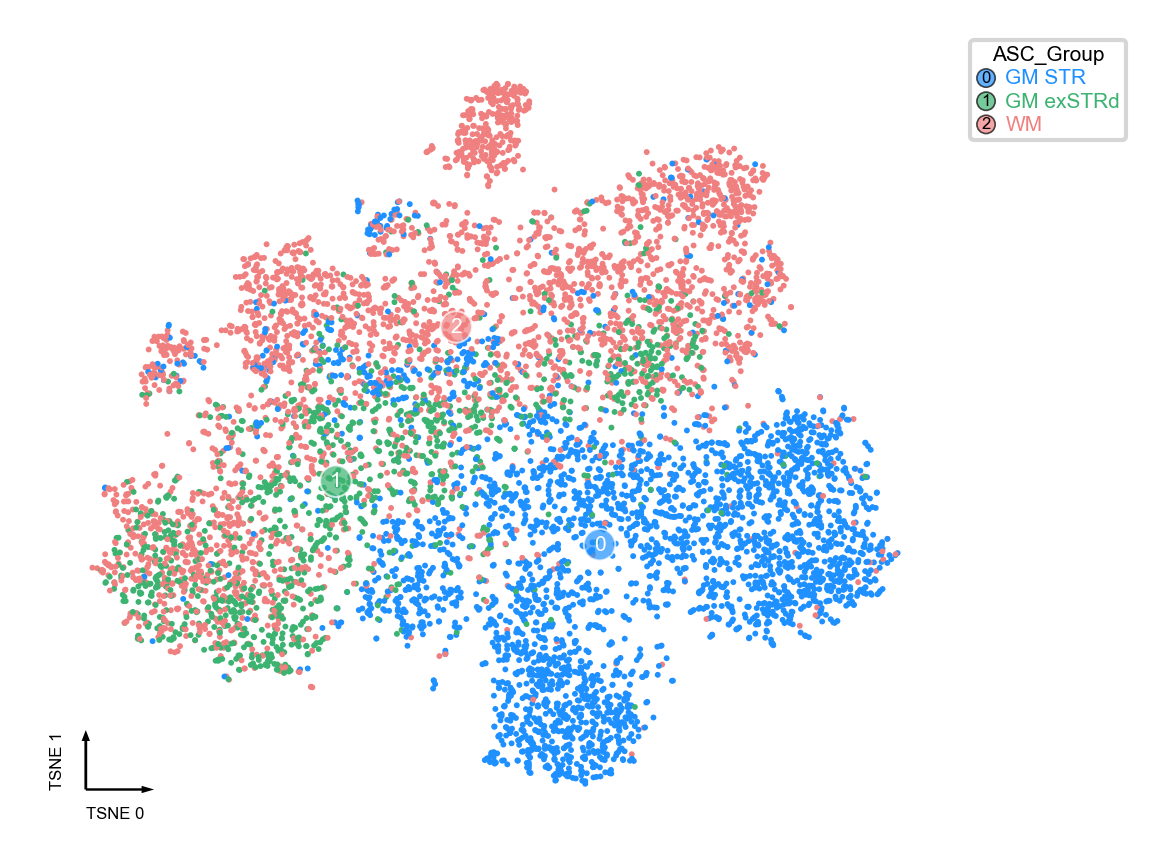

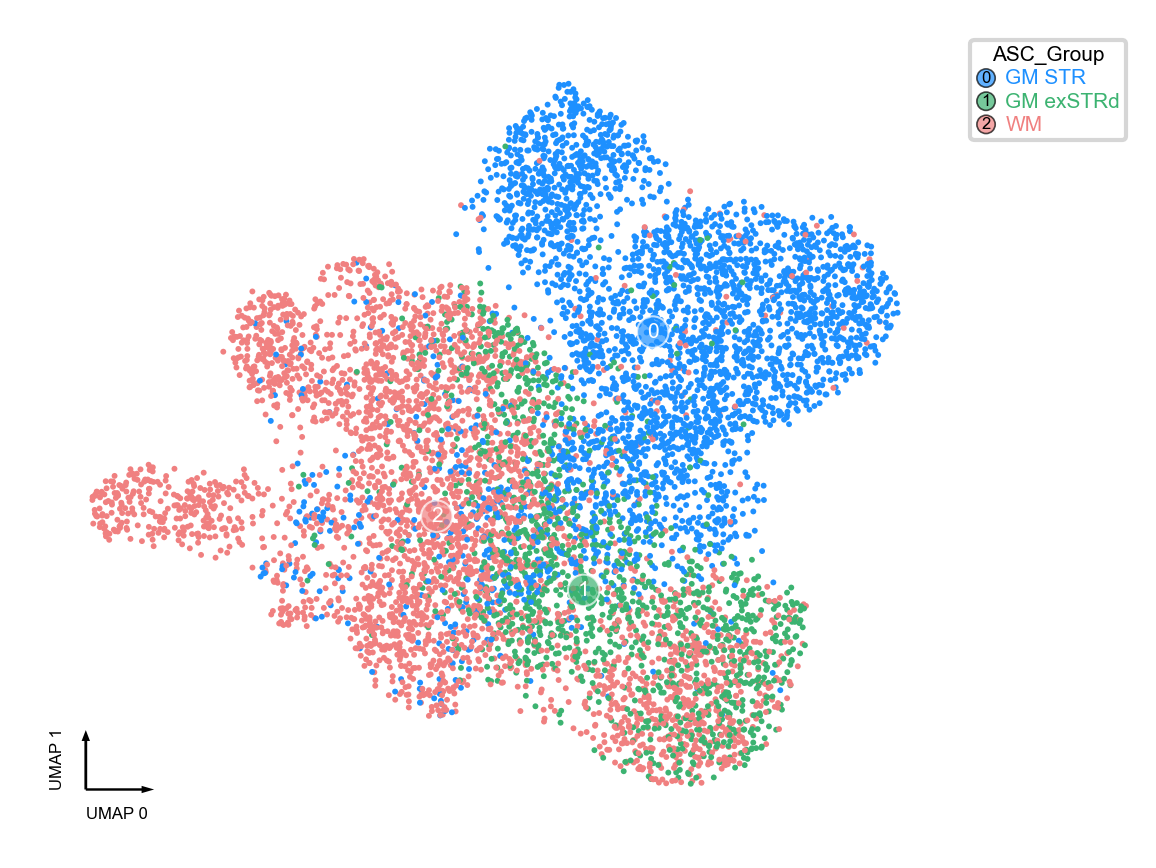

In [13]:
# with code annotation
for coord_base in ['tsne','umap']:
    plot_cluster(adata_path=adata,coord_base=coord_base,cluster_col=clustering_name_annot,
             coding=True,palette_path=group_colors,ncol=1,
             output=f"{fig_basename}.annotated.{coord_base}.{clustering_name_annot}_with_code.pdf",
            # text_anno=None,fontsize=4,legend_fontsize=3,
                )

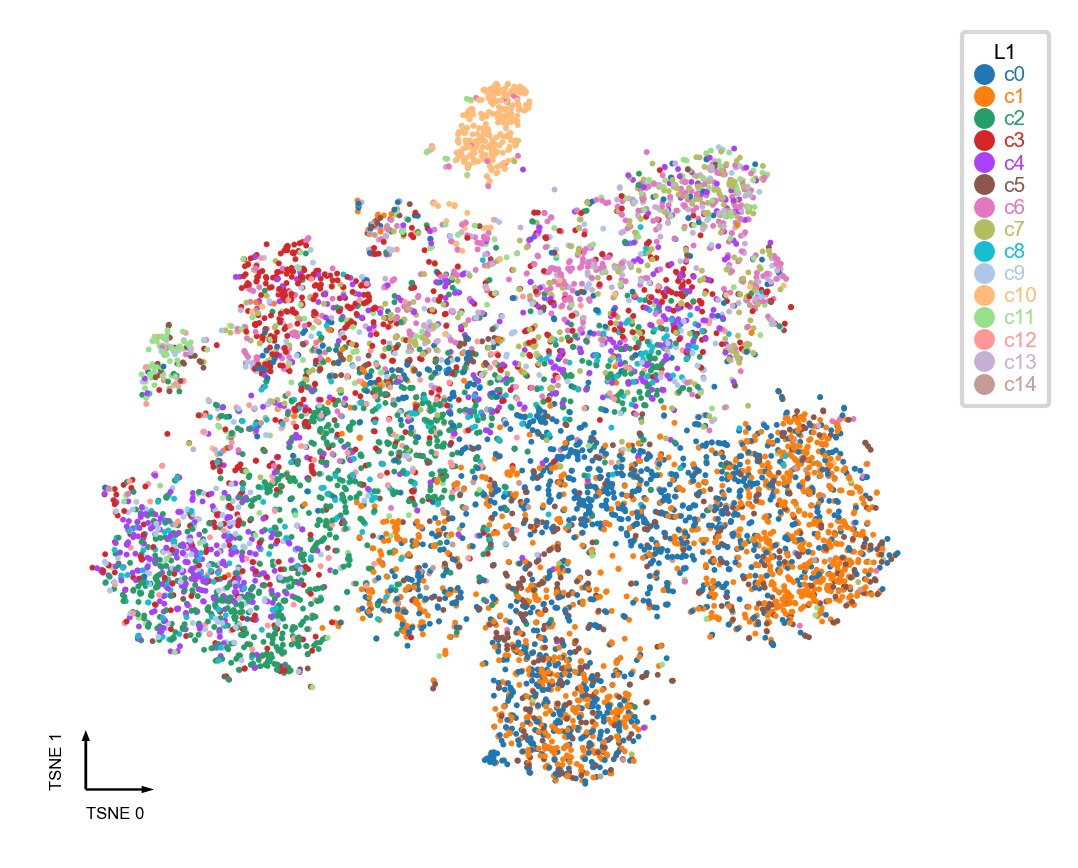

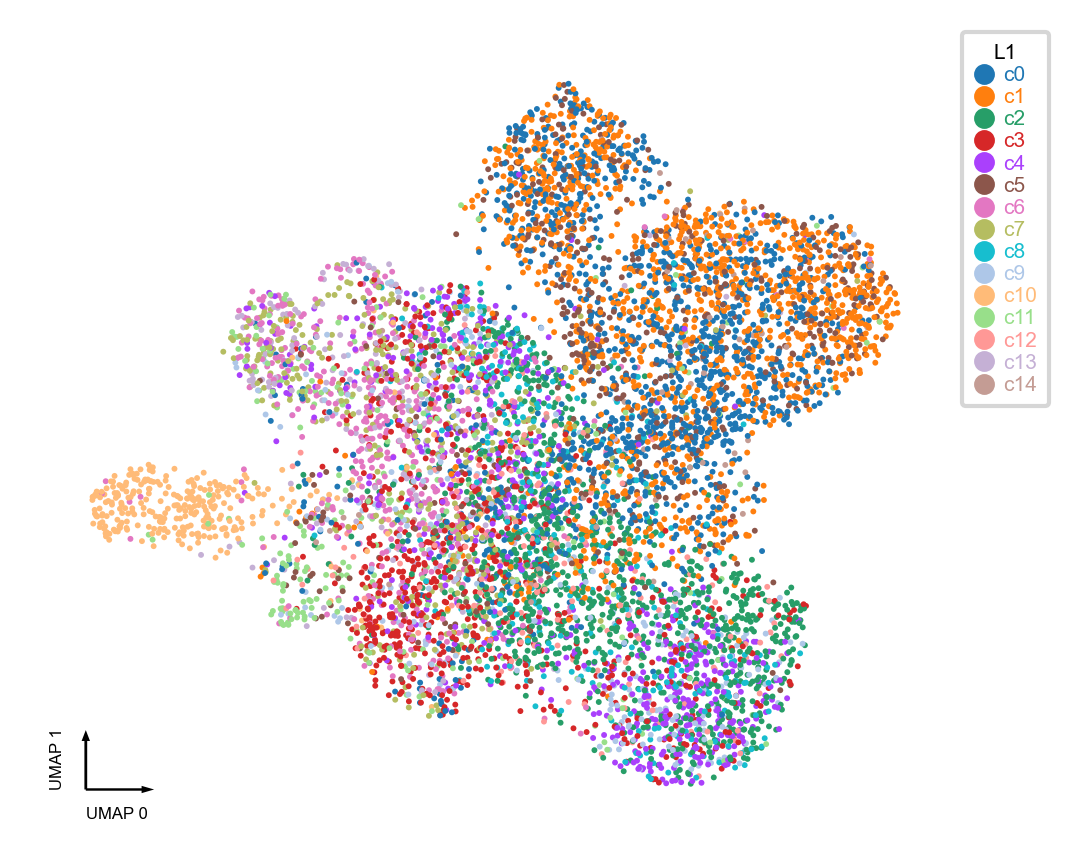

In [14]:
for coord_base in ['tsne','umap']:
    plot_cluster(adata_path=adata,coord_base=coord_base,cluster_col='L1',
         coding=True,palette_path=None,ncol=1,show_legend=True,text_anno=None,
         output=f"{fig_basename}.annotated.{coord_base}.L1.pdf")